In [6]:
import time
import pyvisa
import matplotlib.pyplot as plt
from pathlib import Path

print("All dependency libraries imported successfully!")

All dependency libraries imported successfully!


In [7]:
# Get current file directory and construct absolute paths
current_dir = Path.cwd()
tools_dir = current_dir / "../Tools"

bvc_tools_path = tools_dir / "BVC_Tools.ipynb"

%run $bvc_tools_path
bvcTools = BVCTools()

print("Tool classes imported successfully!")

All dependency libraries imported successfully!
Jupyter signal generator class definition completed!
Tool classes imported successfully!


In [8]:
# Configure device parameters
device_ip = "127.0.0.1"

# Sample rate
sample_rate: int = 4 # 4GHz sample rate

# Storage enable
save_en = {"CH1": True,
           "CH2": True}

# Sampling points
pre_sample = 32 * 1024
pst_sample = 32 * 1024

# File path
save_file_path = "/UserSpace"

# Slice size
save_file_size = 1024 * 1024 * 1024

show_data_nums = 2

In [9]:
# DDC parameters
extract_multiple: int = 2 # Interpolation multiple
NCO_freq: float = 0.0 # NCO frequency

In [10]:
# Trigger parameters
trigger_source: str = "Internal"
in_trigger_repeat: int = 4294967295
in_trigger_cycle: float = 0.001

In [11]:
visa_resource = f'TCPIP::{device_ip}::5555::SOCKET'
        
rm = pyvisa.ResourceManager('@py')

session = rm.open_resource(visa_resource)  # open resource
session.write_termination = '\n'
session.read_termination = '\n'
session.timeout = 50000  # timeout unit: ms
scpi_query = session.query
scpi_write = session.write
scpi_read = session.read

In [12]:
model_info = {}
        
# Device name
device_name = scpi_query(':SYS:DEVice:NAMe? ').replace('\n', '').split(',')
# All module names on the device
module_names = scpi_query(':SYS:DEVice:MODUles?').replace('\n', '').split(',')
for module_name in module_names:
    module_dict = {}
    # Functions supported by this module
    funcs = scpi_query(f':SYS:DEVice:MODUles:FUNC? {module_name}').replace('\n', '').split(',')
    # Query all channels
    in_chnls = []
    out_chnls = []
    for func in funcs:
        if func == 'AWG':
            in_chnls = scpi_query(f':SYS:DEVice:MODUles:CHNLs:OUT? {module_name}').replace('\n', '').split(',')
        if func == 'Digitizer':
            out_chnls = scpi_query(f':SYS:DEVice:MODUles:CHNLs:IN? {module_name}').replace('\n', '').split(',')
    module_dict.setdefault("AWG", in_chnls)
    module_dict.setdefault("Digitizer", out_chnls)
    model_info.setdefault(module_name, module_dict)

print(f"device_name: {device_name}")
print(f"model_info: {model_info}")

device_name: ['TestDevice']
model_info: {'S0_M1210': {'AWG': [], 'Digitizer': []}, 'S0_M2301': {'AWG': [], 'Digitizer': []}, 'S2_M4901': {'AWG': ['CH1', 'CH2'], 'Digitizer': ['CH1', 'CH2']}}


In [13]:
# Module name
module_name = 'S2_M4901'
board_name = 'S0_M1210'
# Channel enable
channel_en = {"CH1": True,
              "CH2": True}

In [14]:
# DDC configuration
scpi_query(f':DAQ:ACQuire:ExtractMultiple {module_name},{extract_multiple}')

for key, value in channel_en.items():
    scpi_query(f':DAQ:CHANnel:DDC:EN {key},{value}')
    if value:
        scpi_query(f':DAQ:CHANnel:DDC:NCOFrequence {key},{NCO_freq}')

In [15]:
# Configure sample rate
scpi_query(f':DAQ:ACQuire:ADC:SRATe {module_name},{sample_rate}')
bvcTools.sync(device_ip, module_name, board_name)

In [16]:
# Trigger configuration
if trigger_source == "Internal":
    scpi_query(f':SAT:TRIGger:SOURce {board_name},Internal')
    scpi_query(f':SAT:TRIGger:INTernal:REPeat {board_name},{in_trigger_repeat}')
    scpi_query(f':SAT:TRIGger:INTernal:CYCle {board_name},{in_trigger_cycle}')

    scpi_query(f':DAQ:TRIGger:SOURce {module_name},PXISTARTrig')
    scpi_query(f':DAQ:TRIGger:INTernal:REPeat {module_name},{in_trigger_repeat}')
    scpi_query(f':DAQ:TRIGger:INTernal:CYCle {module_name},{in_trigger_cycle}')
elif trigger_source == "External":
    scpi_query(f':SAT:TRIGger:SOURce {board_name},External')
    scpi_query(f':DAQ:TRIGger:SOURce {module_name},PXISTARTrig')
else:
    print(f"error: {trigger_source} is no exit")

In [17]:
# Storage
for key, value in save_en.items():
    # Enable data saving
    scpi_query(f':DAQ:UPSTream:SAVe:EN {key},{value}')
    if value:
        # Save path
        scpi_query(f':DAQ:UPSTream:SAVe:DIRectory {key},{save_file_path}')
        # Single file size
        scpi_query(f':DAQ:UPSTream:SAVe:SIZe {key},{save_file_size}')

In [18]:
# Data acquisition
for key, value in channel_en.items():
    # Channel enable
    scpi_query(f':DAQ:CHANnel:EN {key},{value}')
    if value:
        # Quantization bits
        scpi_query(f':DAQ:CHANnel:QUANtization {key},14')
        # Pre-sample points
        # pre_pts: Integer RingBuffer mode, points must be multiple of 32768 bytes; Stream mode, points must be multiple of 64 bytes
        scpi_query(f':DAQ:ACQuire:PRESample {key},{pre_sample}')
        # Post-sample points
        # pst_pts: Integer RingBuffer mode, points must be multiple of 32768 bytes; Stream mode, points must be multiple of 64 bytes
        scpi_query(f':DAQ:ACQuire:PSTSample {key},{pst_sample}')
        

In [19]:
scpi_query(f':SYS:Control:RUN {module_name}')
scpi_query(f':SAT:TRIGger:INTernal:Run {board_name}')

time.sleep(5)

scpi_query(f':SAT:TRIGger:INTernal:Stop {board_name}')
scpi_query(f':SYS:Control:STOP {module_name}')

for key, value in save_en.items():
    # Disable data saving
    scpi_query(f':DAQ:UPSTream:SAVe:EN {key},False')

# View saved data

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Data type mapping
data_type_map = {
    3: np.int8,
    5: np.int16,
    6: np.int16 # QI splicing, each is int16
}
data_type_len_map = {
    np.int8: 1,
    np.int16: 2
}

In [22]:
result_dir = current_dir / 'result' # Result save path
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [23]:
original_list = os.listdir(save_file_path)
# Delete 'WaveList' and 'NSQC'
filtered_list = [item for item in original_list if item not in ['WaveList', 'NSQC']]
# Sort by date and time from newest to oldest
sorted_list = sorted(filtered_list, reverse=True)

In [24]:
file_name = f'{save_file_path}/{sorted_list[0]}/CH1_IQ_0.data' # Raw data path

In [25]:
file_obj = open(file_name, 'rb')
head_length = 32 # Header length
file_len = os.path.getsize(file_name) # Total file length
read_len = 0 # Read file length

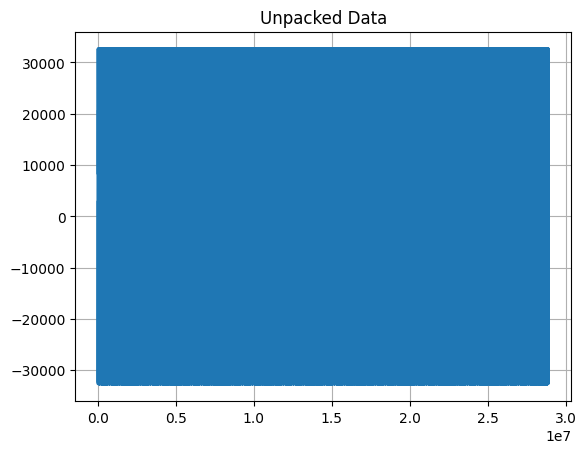

NO.0, prt: 0, read_len: 574121252/57940896


In [27]:
for i in range(show_data_nums):
    head_data = file_obj.read(head_length) # Read header
    read_len += head_length
    pack_length = np.frombuffer(head_data[8:12], dtype=np.uint32)[0] # Packet length
    data_length = pack_length - head_length # Data length
    read_len += data_length
    data_type = np.frombuffer(head_data[24:25], dtype=np.int8)[0] # Data type
    data_type = data_type_map.get(data_type, np.int16) # Data type mapping
    prt = np.frombuffer(head_data[4:8], dtype=np.uint32)[0] # Packet count
    data = np.frombuffer(file_obj.read(data_length), dtype=data_type) # Data
    plt.plot(data)
    plt.title('Unpacked Data')
    plt.grid(True)
    plt.show()
    plt.savefig(f'{result_dir}/unpacked_data_{prt}.png')
    plt.close()
    print(f"NO.{i}, prt: {prt}, read_len: {read_len}/{file_len}")
    if read_len >= file_len:
        break
file_obj.close()

# FFT

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# Data type mapping
data_type_map = {
    3: np.int8,
    5: np.int16,
    6: np.int16 # QI splicing, each is int16
}
data_type_len_map = {
    np.int8: 1,
    np.int16: 2,
}

In [30]:
result_dir = current_dir / 'ttf_result' # Result save path
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [31]:
original_list = os.listdir(save_file_path)
# Delete 'WaveList' and 'NSQC'
filtered_list = [item for item in original_list if item not in ['WaveList', 'NSQC']]
# Sort by date and time from newest to oldest
sorted_list = sorted(filtered_list, reverse=True)

In [32]:
file_name = f'{save_file_path}/{sorted_list[0]}/CH1_IQ_0.data' # Raw data path

In [33]:
file_obj = open(file_name, 'rb')
head_length = 32 # Header length
file_len = os.path.getsize(file_name) # Total file length
read_len = 0 # Read file length

/home/digilab/.conda/envs/JupyterServer/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/digilab/.conda/envs/JupyterServer/lib/python3.10/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/digilab/.conda/envs/JupyterServer/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


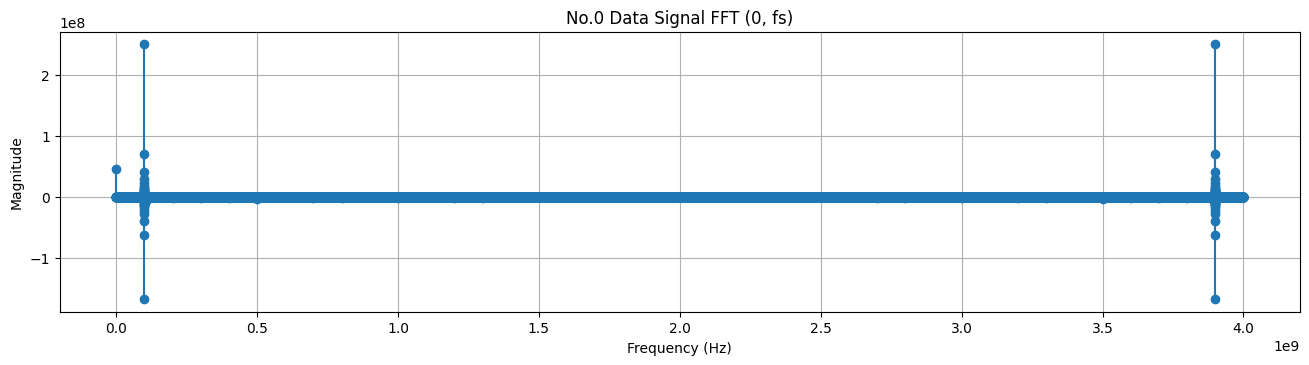

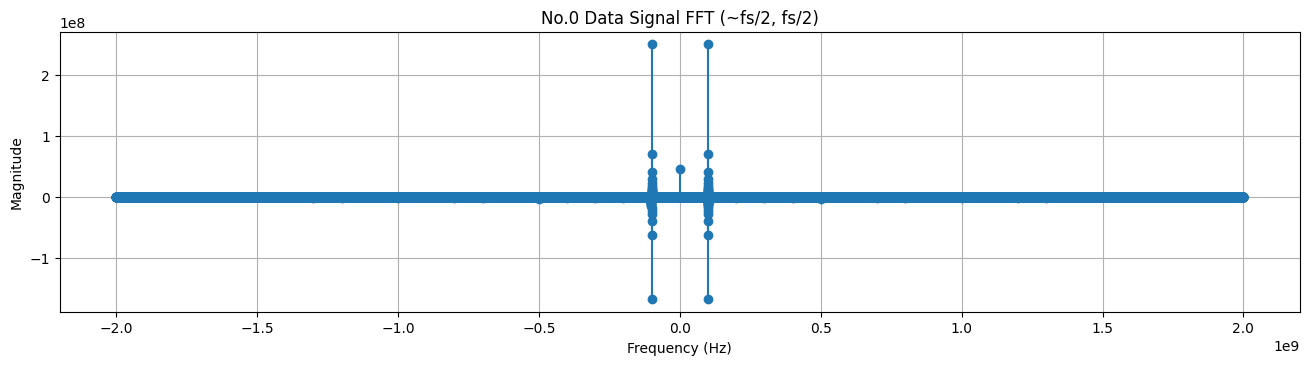

signal fft max: (250600620.4503237+770860688.1372834j)
signal fft shifted max: (250600620.4503237+770860688.1372834j)
NO.0, prt: 0, read_len: 131104/57940896


/tmp/ipykernel_23097/1225779495.py:5: RuntimeWarning: overflow encountered in scalar subtract
  data_length = pack_length - head_length # Data length
/tmp/ipykernel_23097/1225779495.py:6: RuntimeWarning: overflow encountered in scalar add
  read_len += data_length


In [ ]:
for i in range(show_data_nums):
    head_data = file_obj.read(head_length) # Read header
    read_len += head_length
    pack_length = np.frombuffer(head_data[8:12], dtype=np.uint32)[0] # Packet length
    data_length = pack_length - head_length # Data length
    read_len += data_length
    data_type = np.frombuffer(head_data[24:25], dtype=np.int8)[0] # Data type
    data_type = data_type_map.get(data_type, np.int16) # Data type mapping
    prt = np.frombuffer(head_data[4:8], dtype=np.uint32)[0] # Packet count
    data = np.frombuffer(file_obj.read(data_length), dtype=data_type) # Data

    duration = data_length / 4000000000   # Duration (10 us)
    N = int(data_length//data_type_len_map.get(data_type, np.int16))            # Number of points (200 points)
    # Time axis
    t = np.linspace(0, duration, N, endpoint=False)
    
    bvcTools.plot_fft(image_num=i, signal=data, t=t, fs=4000000000)
    
    plt.plot(data)
    plt.title('Unpacked Data')
    plt.grid(True)
    plt.savefig(f'{result_dir}/unpacked_data_{prt}.png')
    plt.close()
    print(f"NO.{i}, prt: {prt}, read_len: {read_len}/{file_len}")
    if read_len >= file_len:
        break
file_obj.close()